In [804]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates
from scipy.stats import linregress
import seaborn as sns

In [805]:
BTC = yf.download("BTC-USD", start="2024-04-10", end="2024-04-11", interval="1m")
LTC = yf.download("LTC-USD", start="2024-04-10", end="2024-04-11", interval="1m")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [806]:
common_indexes = BTC.index.intersection(LTC.index)
BTC = BTC.loc[common_indexes]
LTC = LTC.loc[common_indexes]
BTC.shape, LTC.shape

((1411, 6), (1411, 6))

In [807]:
p1 = BTC['Adj Close']
p2 = LTC['Adj Close']
p1.iloc[0], p2.iloc[0]

(69137.8046875, 97.49980926513672)

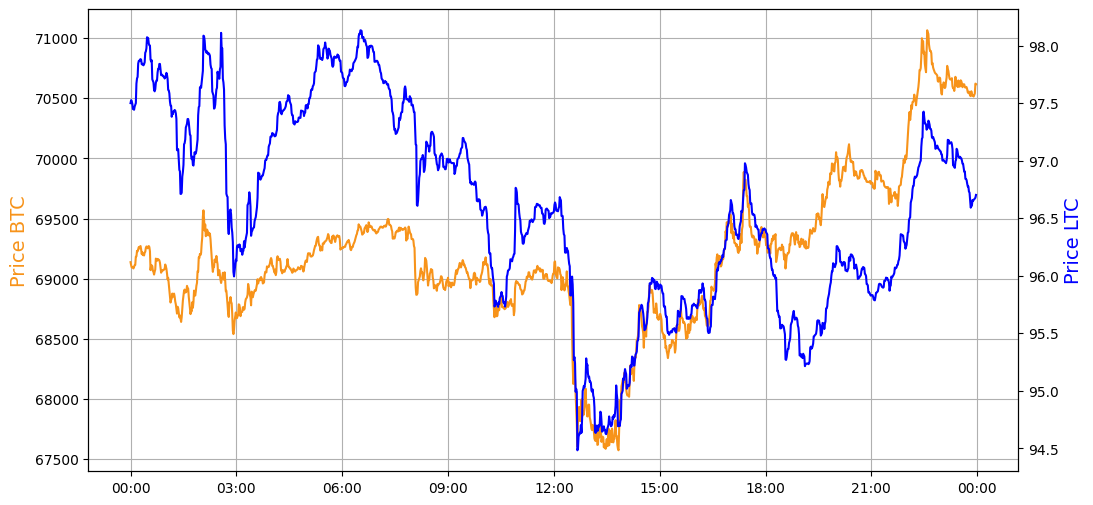

In [808]:
# PRICES PLOT
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(BTC.index, p1, color='#f7931a')
ax1.set_ylabel('Price BTC', color='#f7931a', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(LTC.index, p2, color='blue')
ax2.set_ylabel('Price LTC', color='blue', fontsize=14)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(True)
plt.show()

In [809]:
r_BTC = np.log(p1 / p1.shift(1)).dropna()
r_LTC = np.log(p2 / p2.shift(1)).dropna()

In [810]:
rho = r_BTC.corr(r_LTC, method='pearson')
print(f'Correlation between BTC and LTC: {rho.round(4)}')

Correlation between BTC and LTC: 0.2454


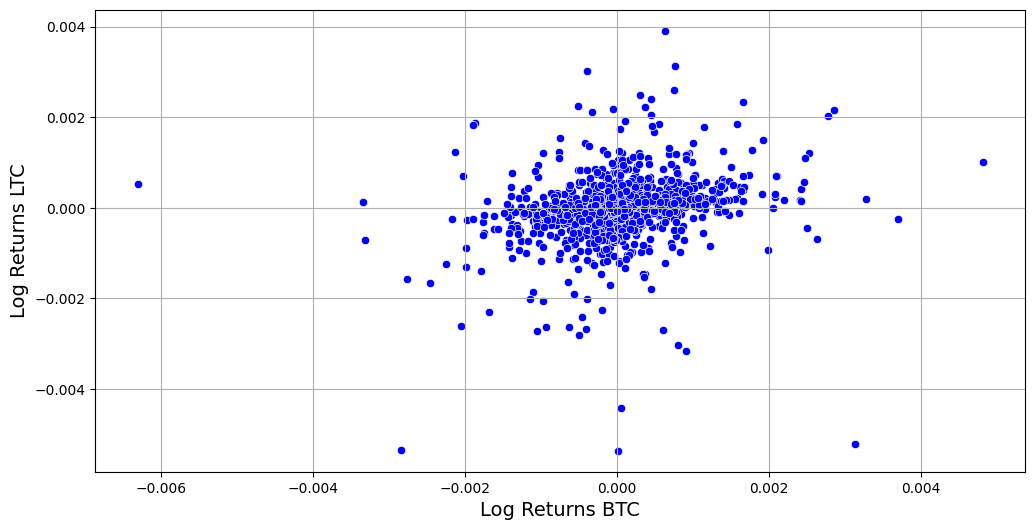

In [811]:
# SCATTRER PLOT WITH LOG RETURNS
plt.figure(figsize=(12, 6))
sns.scatterplot(x=r_BTC, y=r_LTC, color='blue')
plt.xlabel('Log Returns BTC', fontsize=14)
plt.ylabel('Log Returns LTC', fontsize=14)
plt.grid(True)
plt.show()

Beta: 0.4255


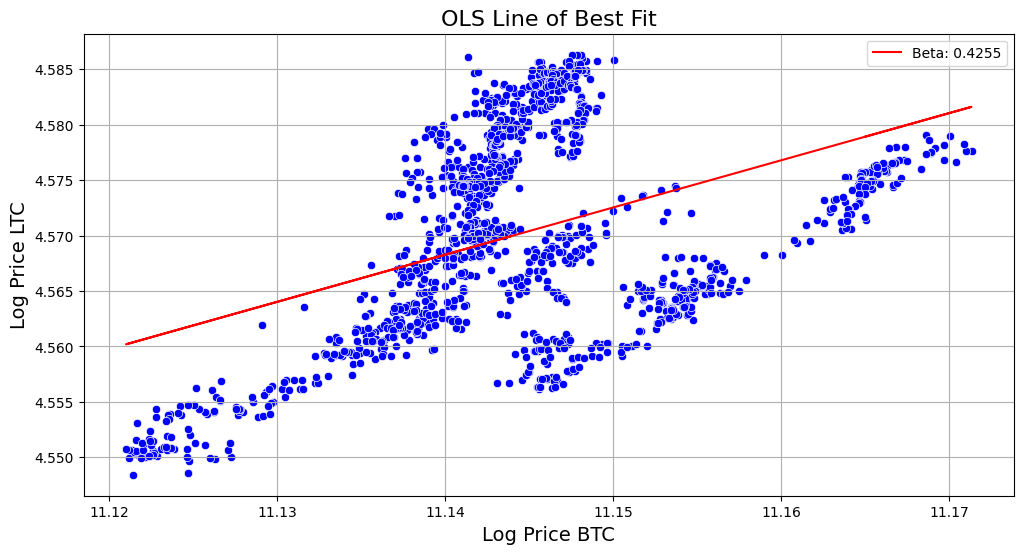

In [812]:
slope, intercept, r_value, p_value, std_err = linregress(np.log(p1), np.log(p2))

beta = slope
print(f'Beta: {beta:.4f}')

# SCATTER PLOT WITH LOG PRICES AND OLS LINE
plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(p1), y=np.log(p2), color='blue')
plt.plot(np.log(p1), beta * np.log(p1) + intercept, color='red', label=f'Beta: {beta:.4f}')
plt.xlabel('Log Price BTC', fontsize=14)
plt.ylabel('Log Price LTC', fontsize=14)
plt.title('OLS Line of Best Fit', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [813]:
S1_0 = BTC['Open'].iloc[0]
S2_0 = LTC['Open'].iloc[0]
mu_1 = r_BTC.mean()*len(BTC)
mu_2 = r_LTC.mean()*len(BTC)
sigma_1 = r_BTC.std()*np.sqrt(len(BTC))
sigma_2 = r_LTC.std()*np.sqrt(len(BTC))
z_0 = 0

In [814]:
print(f'S1_0: {S1_0:.4f}')
print(f'S2_0: {S2_0:.4f}')
print(f'mu_1: {mu_1:.4f}')
print(f'mu_2: {mu_2:.4f}')
print(f'sigma_1: {sigma_1:.4f}')
print(f'sigma_2: {sigma_2:.4f}')

S1_0: 69137.8047
S2_0: 97.4998
mu_1: 0.0212
mu_2: -0.0082
sigma_1: 0.0273
sigma_2: 0.0242


In [815]:
gamma = 0.5
delta = 1
T = 1
M = len(p1)

In [816]:
dt = T / M
S1 = np.zeros((M + 1,  1))
S2 = np.zeros((M + 1,  1))
z = np.zeros((M + 1,  1))
a = np.zeros((M + 1, 1))
b = np.zeros((M + 1, 1))
c = np.zeros((M + 1, 1))
pi_1 = np.zeros((M + 1, 1))
pi_2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
B_t = np.random.standard_normal(z.shape)
B1 = np.random.standard_normal(S1.shape) 
B2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)
                      * ((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * B1[t] + beta
                      * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * B1[t])
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) 
                             * dt + sigma_1 * np.sqrt(dt) * B1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) 
                             * (rho * B1[t] + np.sqrt(1 - rho ** 2) * B2[t]))

Text(0.5, 1.0, 'z')

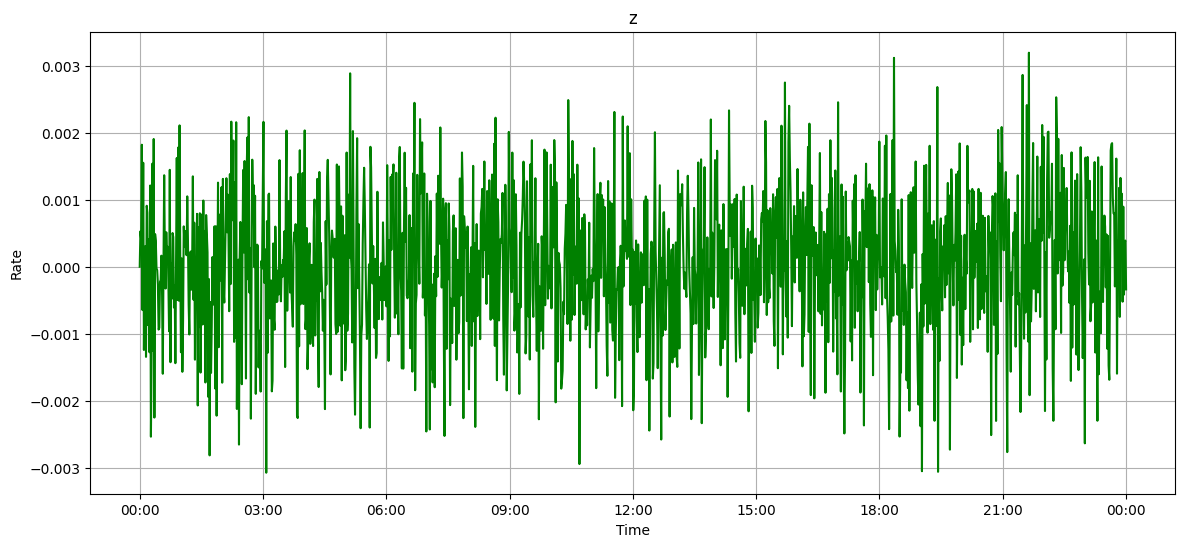

In [825]:
# CO-INTEGRATION VECTOR PLOT
plt.figure(figsize=(14, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.grid(True)
plt.xticks([0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('z')

In [818]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) 
                * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 
                * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 
                + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) 
                + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) 
                + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 
                * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) 
                + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) 
                - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) 
                + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) 
                - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

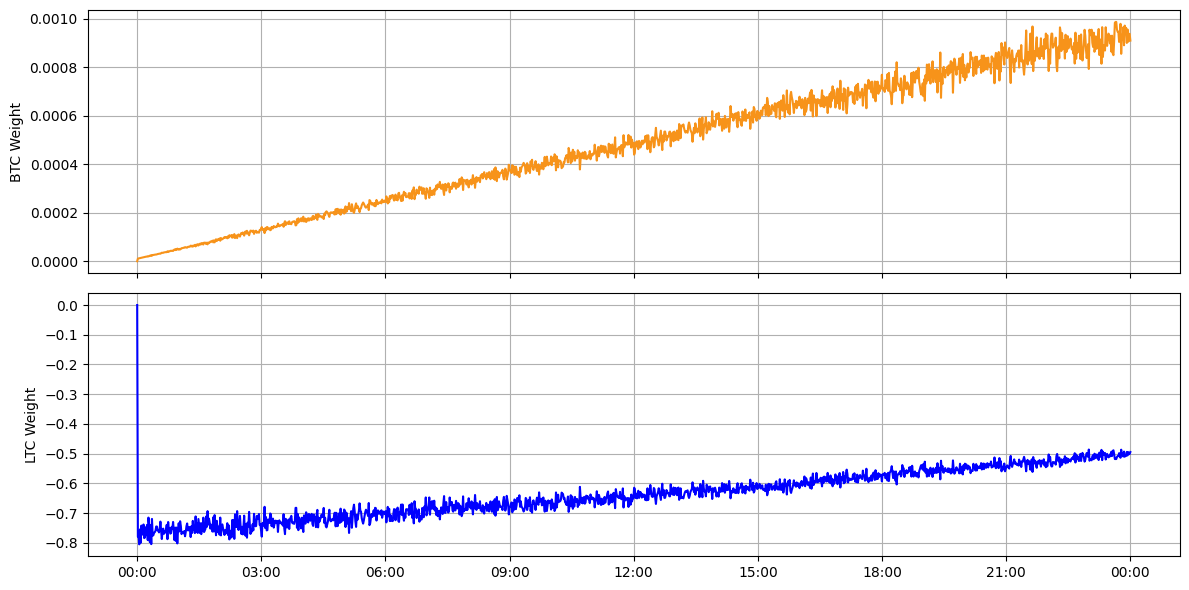

In [819]:
# WEIGHTS PLOT
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top chart: Closing Prices
ax1.plot(tt, pi_1, label='Mid Price', color='#f7931a')
ax1.set_ylabel('BTC Weight')
ax1.grid(True)


# Bottom chart: Returns
ax2.plot(tt, pi_2, label='Minutely Returns', color='b')
ax2.set_ylabel('LTC Weight')
ax2.grid(True)  # Set grid on both major and minor tick marks

# Adjusting the layout
plt.tight_layout()
ax1.set_xticks([0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Show plot
plt.show()

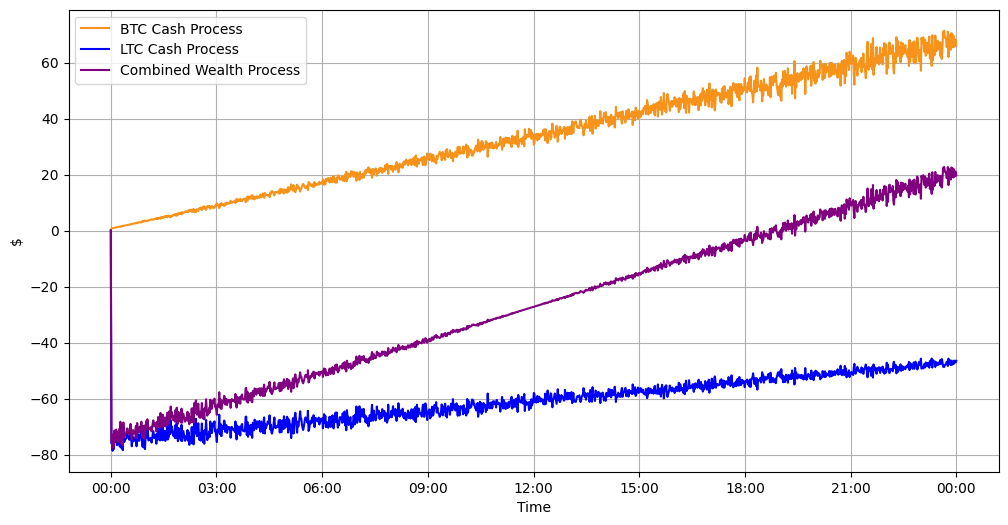

In [820]:
# CASH PROCESSES PLOT
plt.figure(figsize=(12, 6))
plt.plot(tt, pi_1 * S1, '#f7931a', lw=1.5, label='BTC Cash Process')
plt.plot(tt, pi_2 * S2, 'b', lw=1.5, label='LTC Cash Process')
plt.plot(tt, pi_1 * S1 + pi_2 * S2, 'purple', lw=1.5, label='Combined Wealth Process')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.xticks([0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.grid(True)
plt.show()

BTC Weight: 0.0005, LTC Weight: -0.6384


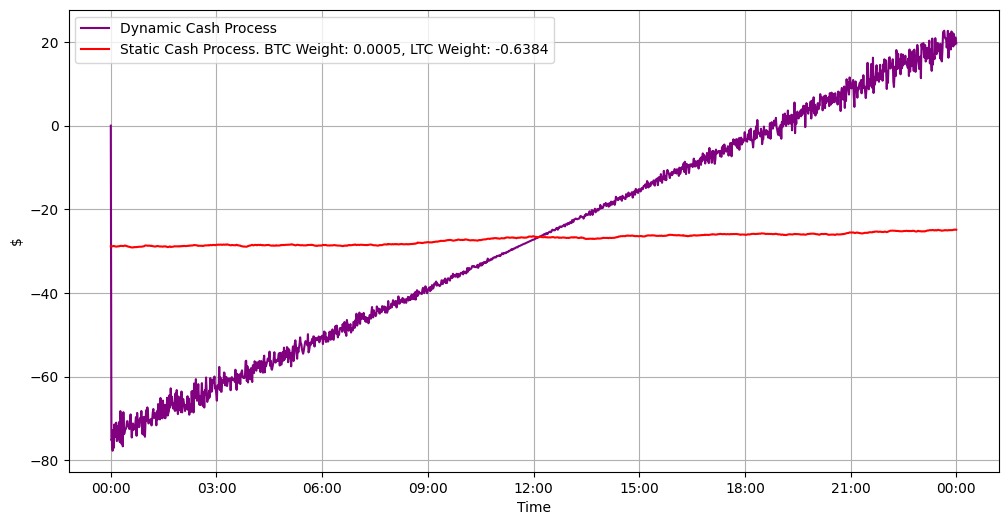

In [824]:
print(f'BTC Weight: {pi_1.mean():.4f}, LTC Weight: {pi_2.mean():.4f}')

#DYNAMIC VS STATIC CASH PROCESSES PLOT
plt.figure(figsize=(12, 6))
plt.plot(tt, pi_1 * S1 + pi_2 * S2, 'purple', lw=1.5, label='Dynamic Cash Process')
plt.plot(tt, pi_1.mean() * S1 + pi_2.mean() * S2, 'r', lw=1.5, label=f'Static Cash Process. BTC Weight: {pi_1.mean():.4f}, LTC Weight: {pi_2.mean():.4f}')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.xticks([0, 0.125, 0.250, 0.375, 0.5, 0.625, 0.75, 0.875, 1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True)